In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [3]:
%pip install astroML


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from astroML.datasets import fetch_rrlyrae_mags

data = fetch_rrlyrae_mags()
# number of objects in dataset

data = data.byteswap().newbyteorder()

df = pd.DataFrame(data)
df.head()

,__SIG2010_,Type,Per,uAmp,T0_u,gAmp,T0_g,rAmp,T0_r,iAmp,...,RAJ2000,DEJ2000,Ar,Dist,umag,gmag,rmag,imag,zmag,Vmag
0,4099,b'ab',0.641754,0.534608,51075.274714,0.563839,51075.288902,0.398326,51075.295112,0.317851,...,0.935679,1.115859,0.089,17.750000,18.134001,16.989000,16.777000,16.702999,16.684999,16.846001
1,13350,b'ab',0.547987,1.029445,54025.330112,1.093322,54025.326856,0.801720,54025.326474,0.642111,...,0.283437,1.178522,0.080,24.770000,18.839001,17.679001,17.544001,17.497000,17.500999,17.570000
2,15927,b'ab',0.612263,0.651579,53680.222485,0.697439,53680.229439,0.486554,53680.226214,0.368674,...,3.254658,-0.584066,0.090,29.120001,19.288000,18.058001,17.858999,17.792000,17.780001,17.921000
3,20406,b'ab',0.631853,0.553247,54000.280528,0.586784,54000.292109,0.426846,54000.276631,0.342734,...,3.244369,0.218891,0.088,9.130000,16.715000,15.543000,15.336000,15.286000,15.276000,15.403000
4,21992,b'ab',0.625880,1.109322,53698.245218,1.139930,53698.245256,0.849551,53698.243534,0.661144,...,4.315354,1.054582,0.077,7.350000,16.186001,15.040000,14.909000,14.864000,14.853000,14.932000


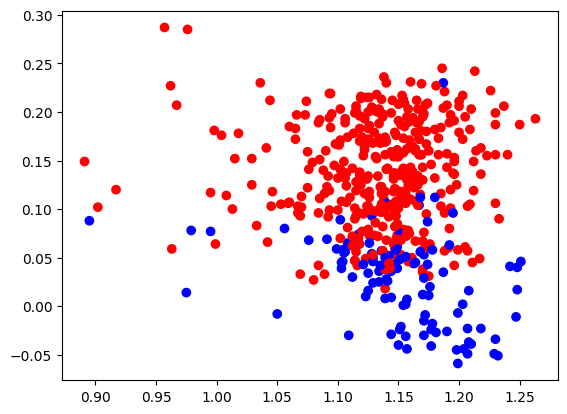

In [5]:
df['u-g'] = df['umag'] - df['gmag']
df['g-r'] = df['gmag'] - df['rmag']
df['r-i'] = df['rmag'] - df['imag']
df['i-z'] = df['imag'] - df['zmag']

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'))

Objective function

In [6]:
def phi(A, u):
    return sum(u[i]*np.dot(A[i].T, A[i])for i in range(len(u))) - np.dot(sum(u[i]*A[i] for i in range(len(u))).T,sum(u[i]*A[i] for i in range(len(u))))

In [7]:
def LMO(gradient):
    lmo = np.argmin(gradient)
    return lmo

In [8]:
def vertex_computation(set_weights, gradient, dimension_m):
    weight_indexes = np.where(set_weights > 0)[0]
    max_gradient_index = np.argmax(gradient[weight_indexes])
    v_index = weight_indexes[max_gradient_index]
    v = np.zeros(dimension_m)
    v[v_index] = 1.0
    return v, v_index

Armijo Method

In [9]:
def armijo_method(A, u, alpha = 0.9, delta = 0.5, gamma = 0.1, max_iter=100):   
    gradient = np.matmul(2 * np.matmul(A, A.T), u) - np.sum(np.square(A), axis=1)
    gradient_norm = np.linalg.norm(gradient)
    phi_u = -phi(A, u) # Negative objective function
    for i in range(max_iter):
        
        new_u = u - alpha * gradient # Update u
        phi_new_u = -phi(A, new_u) # Update function

        if phi_new_u <= phi_u - gamma * alpha * gradient_norm ** 2: # Armijo condition
            return alpha
        
        alpha *= delta # Reduce alpha
    return alpha

In [10]:
def exact_line_search_method(A, direction, gradient):
    numerator = np.matmul(gradient.T, direction)
    denominator = 2 * np.matmul(np.matmul(direction.T, np.matmul(A, A.T)), direction)
    return abs(numerator/ denominator)

Awaystep

In [11]:
def frankWolfe_AwayStep(A, epsilon, max_iterations=10000, step_size = "Exact"):
    
    total_time = 0
    count_FrankWolfe = 0
    count_AwayStep = 0
    count_dropped = 0 
    count_iterations = 0
    dual_val_list = []
    dual_gap_list = []

    m, n = A.shape

    # initialize u vector
    u = np.zeros(m)
    u[0] = 1.0

    # Create set S containing the u values across time
    S_set = np.zeros(m)
    S_set[np.where(u > 0)[0]] = 1

    if step_size == "Lipschitz":
        H = 2 * np.matmul(A, A.T)
        eigen_values = np.linalg.eigvalsh(H)
        L = np.max(eigen_values)
        alpha = 1/L

    for i in range(max_iterations):
        time_start = time.time()

        dual_val = -phi(A, u) # We minimize the negative objective function
        dual_val_list.append(dual_val) # Keep track of the changes in the objective function across iterations

        gradient = np.matmul(2 * np.matmul(A, A.T), u) - np.sum(np.square(A), axis=1) # Gradient computation
        # FW direction
        s_index= LMO(gradient) 
        s = np.zeros(m)
        s[s_index] = 1.0
        direction_FrankWolfe = s - u
        
        # AW direction
        v, v_index = vertex_computation(S_set, gradient, m)
        direction_AwayStep = u - v

        # Stopping criterion
        gap_FrankWolfe = -gradient.T @ direction_FrankWolfe 
        dual_gap_list.append(gap_FrankWolfe) 
        if gap_FrankWolfe <= epsilon:
            comp_time = time.time() - time_start
            total_time = comp_time + total_time
            # CPU_time_list.append(total_time)
            # active_set_size_list.append(int(np.sum(np.abs(S_t) >= 0.0001))) # Used to track the active set size over time for plotting purposes
            break

        count_iterations += 1

        # Compare and choose between FW and AS 
        gap_AwayStep = -gradient.T @ direction_AwayStep 
        if gap_FrankWolfe >= gap_AwayStep:
            # Frank-Wolfe 
            direction_chosen = direction_FrankWolfe
            max_alpha = 1  # Max step-size FW
            frankwolfe_flag = True
        else:
            # Away-step
            direction_chosen = direction_AwayStep
            max_alpha = S_set[v_index] / (1 - S_set[v_index]) # Max step-size AS
            frankwolfe_flag = False

        # alpha = calculate_step_size(line_search_strategy, i, A_squared, u, Z, direction_chosen, gradient, max_alpha)
        # Step-size
        if step_size == "Harmonic":
            alpha = 2 / (i + 1) 
        if step_size == "Armijo":
            alpha = armijo_method(A, u)
        if step_size == "Exact":
            alpha = exact_line_search_method(A, direction_chosen, gradient)
        alpha = max(0.0, min(alpha, max_alpha))

        # update u
        u = u + (alpha * direction_chosen)

        # Update set S
        if frankwolfe_flag: # FW step
            S_set = (1 - alpha) * S_set # alpha_v update
            S_set[s_index] = S_set[s_index] + alpha # alpha_S_t update
            if alpha > 0.999999: # step-size is max
                # Set S = {s_t}
                S_set = np.zeros(m)
                S_set[s_index] = 1 
            count_FrankWolfe += 1 
        else: # AS step
            S_set = (1 + alpha) * S_set # alpha_v update
            count_AwayStep += 1
            if abs(alpha - max_alpha) < 0.000001: # step-size is max
                count_dropped += 1
                S_set[v_index] = 0 # drop step
            else:
                S_set[v_index] = S_set[v_index] - alpha # alpha_V_t update
        # active_set_size_list.append(int(np.sum(np.abs(S_t) > 0))) # Used to track the active set size over time for plotting purposes\
        
        iteration_time = time.time() - time_start
        total_time = total_time + iteration_time
        # CPU_time_list.append(total_time) # Used to track the total time over time for plotting purposes REMOVE LATER??

    radius = np.sqrt(-dual_val)
    center = np.matmul(A.T, u)

    return center, radius, count_iterations, total_time, dual_val_list, dual_gap_list

Pairwise

In [12]:
def frankWolfe_Pairwise(A, epsilon, max_iterations=10000, step_size = "Exact"):
    
    total_time = 0
    count_iterations = 0
    dual_val_list = []
    dual_gap_list = []
    
    m, n = A.shape

    # initialize u vector
    u = np.zeros(m)
    u[0] = 1.0

    # Create set S containing the u values across time
    S_set = np.zeros(m)
    S_set[np.where(u > 0)[0]] = 1

    if step_size == "Lipschitz":
        H = 2 * np.matmul(A, A.T)
        eigen_values = np.linalg.eigvalsh(H)
        L = np.max(eigen_values)
        alpha = 1/L

    for i in range(max_iterations):
        time_start = time.time()

        dual_val = -phi(A, u) # We minimize the negative objective function
        dual_val_list.append(dual_val) # Keep track of the changes in the objective function across iterations
        
        gradient = np.matmul(2 * np.matmul(A, A.T), u) - np.sum(np.square(A), axis=1) # Gradient computation
        
        # Compute the Pairwise direction
        s_index= LMO(gradient)
        s = np.zeros(m)
        s[s_index] = 1.0
        v, v_index = vertex_computation(S_set, gradient, m)
        direction_Pairwise = s - v

        # Stopping criterion
        gap_FrankWolfe = -gradient.T @ direction_Pairwise
        dual_gap_list.append(gap_FrankWolfe) 
        if gap_FrankWolfe <= epsilon:
            comp_time = time.time() - time_start
            total_time = comp_time + total_time
            # CPU_time_list.append(total_time)
            # active_set_size_list.append(int(np.sum(np.abs(S_t) >= 0.0001))) # Used to track the active set size over time for plotting purposes
            break

        count_iterations += 1

        # Step-size
        if step_size == "Harmonic":
            alpha = 2 / (i + 1)
        if step_size == "Armijo":
            alpha = armijo_method(A, u)
        if step_size == "Exact":
            alpha = exact_line_search_method(A, direction_Pairwise, gradient)
        alpha = min(alpha, S_set[v_index])

        # update u
        u = u + (alpha * direction_Pairwise)

        # Update set S
        S_set[v_index] = S_set[v_index] - alpha # alpha_V_t update
        S_set[s_index] = S_set[s_index] + alpha # alpha_S_t update

        iteration_time = time.time() - time_start
        total_time = total_time + iteration_time
        # CPU_time_list.append(total_time) # Used to track the total time over time for plotting purposes REMOVE LATER??

    radius = np.sqrt(-dual_val)
    center = np.matmul(A.T, u)
    
    return center, radius, count_iterations, total_time, dual_val_list, dual_gap_list

Accuracy Measure

In [61]:
def measure_accuracy(negative_class, positive_class, df):
    """
    Measure the accuracy of a classifier by calculating the precision, recall, and F1 score.
    """
    # Count of true positive (TP)
    tp = df[(df['type'] == positive_class) & (df['InsideBall'] == True)]['type'].count()

    # Count of false negative (FN)
    fn = df[(df['type'] == positive_class) & (df['InsideBall'] == False)]['type'].count()

    # Count of true negative (TN)
    tn = df[(df['type'] == negative_class) & (df['InsideBall'] == False)]['type'].count()

    # Count of false positive (FP)
    fp = df[(df['type'] == negative_class) & (df['InsideBall'] == True)]['type'].count()

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create a table
    table_data = {
        'Metric': ['True Positive (TP)', 'False Negative (FN)', 'True Negative (TN)', 'False Positive (FP)', 'Precision', 'Recall', 'F1 Score'],
        'Count': [tp, fn, tn, fp, precision, recall, f1_score]
    }

    table_df = pd.DataFrame(table_data)

    # Display the table
    return table_df

Generated Data

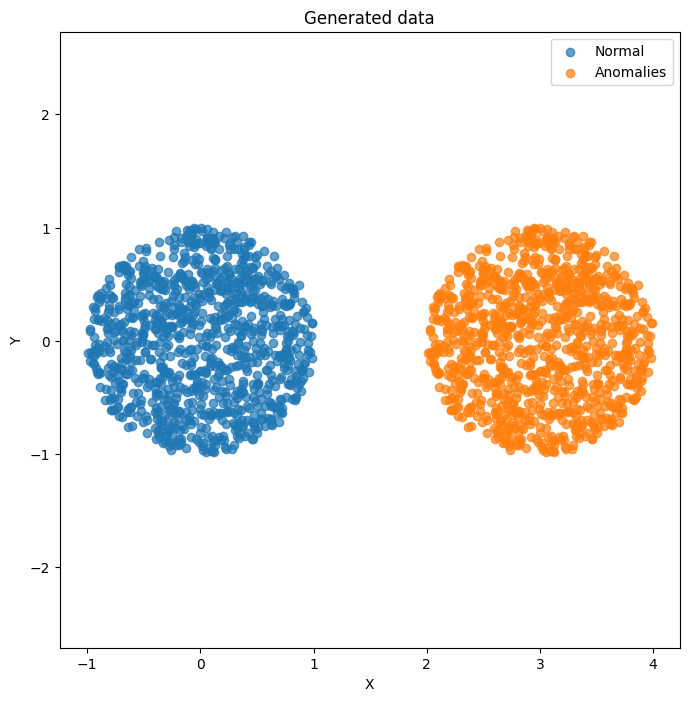

In [14]:
def generate_non_overlapping_circular_data(n_points, radius, center1, center2):

    angles = np.random.uniform(0, 2 * np.pi, n_points)
    radii = np.sqrt(np.random.uniform(0, 1, n_points)) * radius
    
    x1 = radii * np.cos(angles) + center1[0]
    y1 = radii * np.sin(angles) + center1[1]
    set1 = np.column_stack((x1, y1))
    
    x2 = radii * np.cos(angles) + center2[0]
    y2 = radii * np.sin(angles) + center2[1]
    set2 = np.column_stack((x2, y2))

    return set1, set2

n_points = 1000
radius = 1
center1 = (0, 0)  # Center of the first circle
center2 = (3, 0)  # Center of the second circle 
normal, anomalies = generate_non_overlapping_circular_data(n_points, radius, center1, center2)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(normal[:, 0], normal[:, 1], alpha=0.7, label='Normal')
plt.scatter(anomalies[:, 0], anomalies[:, 1], alpha=0.7, label='Anomalies')
plt.title('Generated data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()

Awaystep generated data

In [15]:
epsilon = 0.001

center_AS_gd, radius_AS_gd, count_iterations_AS_gd, total_time_AS_gd, dual_val_list_AS_gd, dual_gap_list_AS_gd = frankWolfe_AwayStep(normal, epsilon, max_iterations=10000, step_size= "Exact")

print("CENTER: ", center_AS_gd)
print("RADIUS: ", radius_AS_gd)
print("COUNT ITERATIONS: ", count_iterations_AS_gd)
print("TOTAL TIME: ", total_time_AS_gd)

CENTER:  [2.74958395e-04 4.10900383e-05]
RADIUS:  0.9990700438987901
COUNT ITERATIONS:  253
TOTAL TIME:  2.4552409648895264


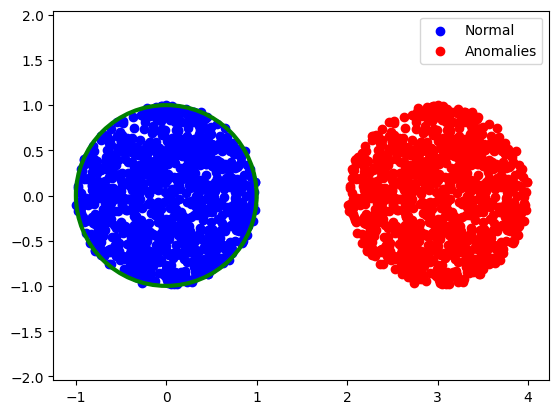

In [16]:
fig, ax = plt.subplots()

# Scatter plot for normal data points and anomalies
plt.scatter(normal[:, 0], normal[:, 1], color='blue', label='Normal')
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='red', label='Anomalies')

# Create and add the circle patch
circle = plt.Circle(tuple(center_AS_gd), radius_AS_gd, color='g', fill=False, linewidth=3)
ax.add_patch(circle)

# Set plot properties
plt.axis('equal')
plt.legend()

# Display the plot
plt.show()

Pairwise generated data

In [17]:
epsilon = 0.001

center_PWF_gd, radius_PWF_gd, count_iterations_PWF_gd, total_time_PWF_gd, dual_val_list_PWF_gd, dual_gap_list_PWF_gd = frankWolfe_Pairwise(normal, epsilon, max_iterations=10000, step_size="Exact")

print("CENTER: ", center_PWF_gd)
print("RADIUS: ", radius_PWF_gd)
print("COUNT ITERATIONS: ", count_iterations_PWF_gd)
print("TOTAL TIME: ", total_time_PWF_gd)

CENTER:  [0.00014008 0.00017652]
RADIUS:  0.9992890493642291
COUNT ITERATIONS:  148
TOTAL TIME:  1.3274013996124268


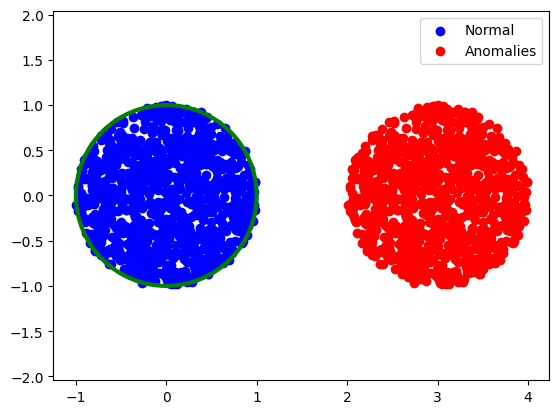

In [18]:
fig, ax = plt.subplots()

# Scatter plot for normal data points and anomalies
plt.scatter(normal[:, 0], normal[:, 1], color='blue', label='Normal')
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='red', label='Anomalies')

# Create and add the circle patch
circle = plt.Circle(tuple(center_PWF_gd), radius_PWF_gd, color='g', fill=False, linewidth=3)
ax.add_patch(circle)

# Set plot properties
plt.axis('equal')
plt.legend()

# Display the plot
plt.show()

AwayStep with 2 variables

In [19]:
# we supply: A, epsilon, max_iterations=1000
A = df[df['Type']==b'ab'][['u-g', 'g-r']].values
epsilon = 0.001

center_AS, radius_AS, count_iterations_AS, total_time_AS, dual_val_list_AS, dual_gap_list_AS = frankWolfe_AwayStep(A, epsilon, max_iterations=10000, step_size  = "Exact")

print("CENTER: ", center_AS)
print("RADIUS: ", radius_AS)
print("COUNT ITERATIONS: ", count_iterations_AS)
print("TOTAL TIME: ", total_time_AS)

CENTER:  [1.07906072 0.15877132]
RADIUS:  0.18709602412601886
COUNT ITERATIONS:  5
TOTAL TIME:  0.03710436820983887


In [20]:
pred_columns = ['u-g', 'g-r']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(df[pred_columns] - center_AS, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_AS

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)


,Metric,Count
0,True Positive (TP),377.000000
1,False Negative (FN),2.000000
2,True Negative (TN),35.000000
3,False Positive (FP),69.000000
4,Precision,0.845291
5,Recall,0.994723
6,F1 Score,0.913939


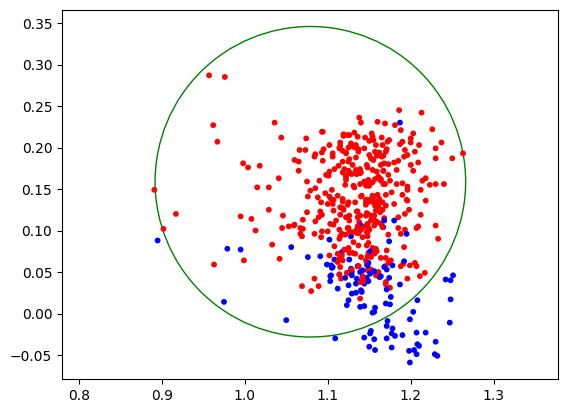

In [21]:
circle = plt.Circle(tuple(center_AS), radius_AS, color='g', fill=False)

ax = plt.gca()
ax.cla()
ax.add_patch(circle)
plt.axis('equal')
plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'), s=10)

Pairwise with 2 variables

In [22]:
# we supply: A, epsilon, max_iterations=1000
A = df[df['Type']==b'ab'][['u-g', 'g-r']].values
epsilon = 0.001

center_PFW, radius_PFW, count_iterations_PFW, total_time_PFW, dual_val_list_PFW, dual_gap_list_PFW = frankWolfe_Pairwise(A, epsilon, max_iterations=10000, step_size="Exact")

print("CENTER: ", center_PFW)
print("RADIUS: ", radius_PFW)
print("COUNT ITERATIONS: ", count_iterations_PFW)
print("TOTAL TIME: ", total_time_PFW)


CENTER:  [1.07772276 0.16791147]
RADIUS:  0.18732271829313332
COUNT ITERATIONS:  3
TOTAL TIME:  0.0063838958740234375


In [23]:
pred_columns = ['u-g', 'g-r']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(df[pred_columns] - center_PFW, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_PFW

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),377.000000
1,False Negative (FN),2.000000
2,True Negative (TN),35.000000
3,False Positive (FP),69.000000
4,Precision,0.845291
5,Recall,0.994723
6,F1 Score,0.913939


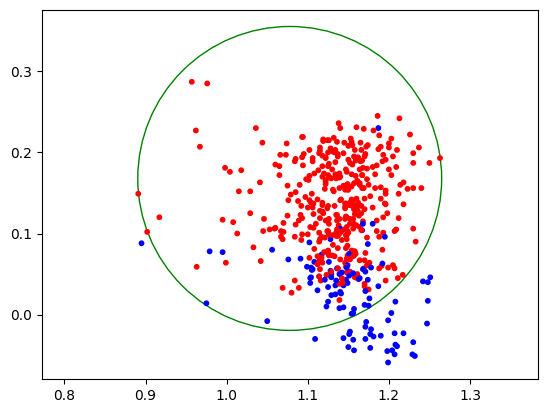

In [24]:
circle = plt.Circle(tuple(center_PFW), radius_PFW, color='g', fill=False)

ax = plt.gca()
ax.cla()
ax.add_patch(circle)

plt.axis('equal')
plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'), s=10)

Data imbalance

In [25]:
print(sum((df["Type"] == b'ab')) / df["Type"].count())
print(sum((df["Type"] == b'ab')))
print(sum((df["Type"] == b'c ')))

0.7846790890269151
379
104


Using the Full Dataset

In [26]:
Full_dataset = df[df['Type'] == b'ab'].drop('Type', axis=1).drop("InsideBall", axis = 1).values

Standardized Full Dataset

In [27]:
# Standardize the dataset
Full_dataset_mean = np.mean(Full_dataset, axis=0)
Full_dataset_std = np.std(Full_dataset, axis=0)

Standardized_full_dataset = (Full_dataset - Full_dataset_mean) / Full_dataset_std

Awaystep Full Dataset Harmonic

In [28]:
epsilon = 0.001

center_AS_fdh, radius_AS_fdh, count_iterations_AS_fdh, total_time_AS_fdh, dual_val_list_AS_fdh, dual_gap_list_AS_fdh = frankWolfe_AwayStep(Full_dataset, epsilon, max_iterations=10000, step_size  = "Harmonic")

print("CENTER: ", center_AS_fdh)
print("RADIUS: ", radius_AS_fdh)
print("COUNT ITERATIONS: ", count_iterations_AS_fdh)
print("TOTAL TIME: ", total_time_AS_fdh)

KeyboardInterrupt: 

In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(df[pred_columns] - center_AS_fdh, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_AS_fdh

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),378.000000
1,False Negative (FN),1.000000
2,True Negative (TN),1.000000
3,False Positive (FP),103.000000
4,Precision,0.785863
5,Recall,0.997361
6,F1 Score,0.879070


Text(0, 0.5, 'Function value')

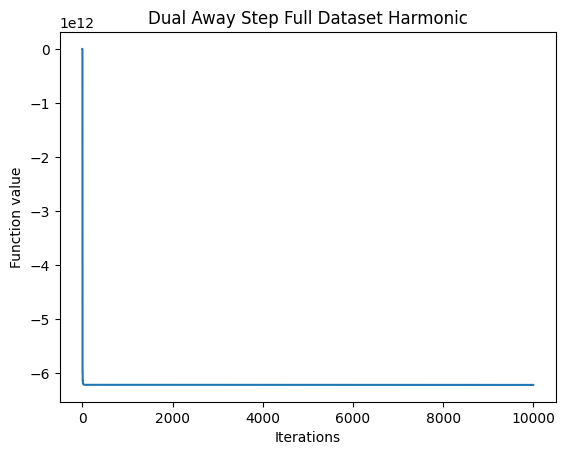

In [ ]:
plt.plot(dual_val_list_AS_fdh)
plt.title('Dual Away Step Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

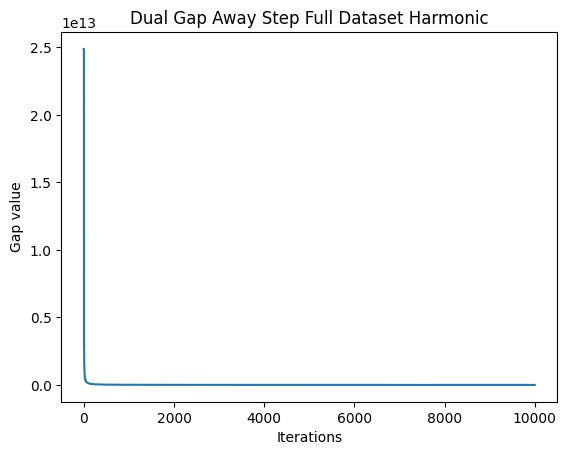

In [ ]:
plt.plot(dual_gap_list_AS_fdh)
plt.title('Dual Gap Away Step Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Awaystep Standardized Full Dataset Harmonic

In [ ]:
epsilon = 0.001

center_AS_sdh, radius_AS_sdh, count_iterations_AS_sdh, total_time_AS_sdh, dual_val_list_AS_sdh, dual_gap_list_AS_sdh = frankWolfe_AwayStep(Standardized_full_dataset, epsilon, max_iterations=10000, step_size="Harmonic")

print("CENTER: ", center_AS_sdh)
print("RADIUS: ", radius_AS_sdh)
print("COUNT ITERATIONS: ", count_iterations_AS_sdh)
print("TOTAL TIME: ", total_time_AS_sdh)

CENTER:  [-0.17200729 -0.50563098 -0.19428317 -1.02988687  0.15594565 -1.02985741
  0.31780663 -1.02984731  0.58327228 -1.02986383 -1.02980994 -0.61471622
  0.24771304  0.29154857  1.45758624  0.06776956  0.10606798  0.08469749
  0.10186562  0.05656655  0.09567602 -1.19419844  0.66839887 -0.96238038
  2.41352499]
RADIUS:  9.221514435663684
COUNT ITERATIONS:  10000
TOTAL TIME:  43.00611996650696


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm((df[pred_columns] - np.mean(Full_dataset, axis=0)) / np.std(Full_dataset, axis=0) - center_AS_sdh, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_AS_sdh

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),377.000000
1,False Negative (FN),2.000000
2,True Negative (TN),28.000000
3,False Positive (FP),76.000000
4,Precision,0.832230
5,Recall,0.994723
6,F1 Score,0.906250


Text(0, 0.5, 'Function value')

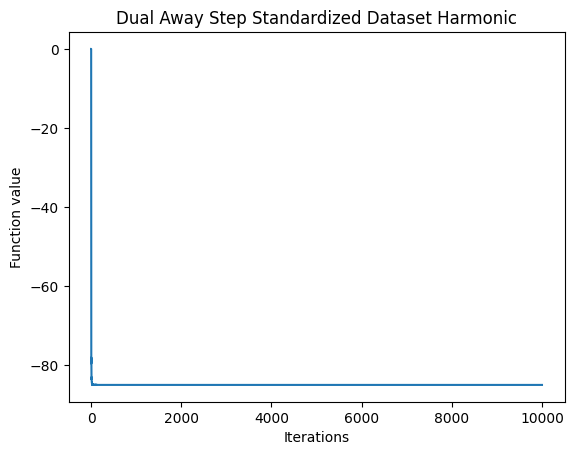

In [ ]:
plt.plot(dual_val_list_AS_sdh)
plt.title('Dual Away Step Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

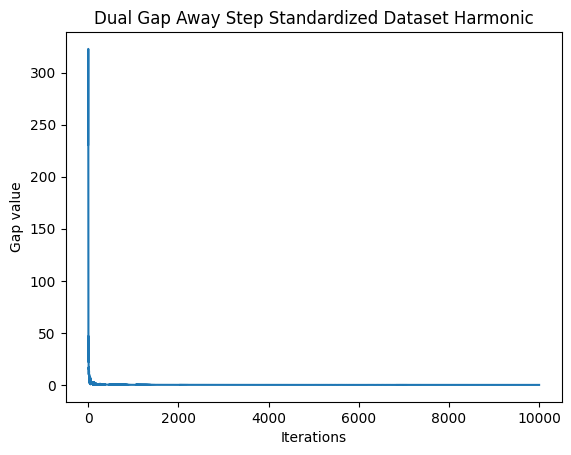

In [ ]:
plt.plot(dual_gap_list_AS_sdh)
plt.title('Dual Gap Away Step Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Awaystep Full Dataset Armijo

In [ ]:
epsilon = 0.001

center_AS_fda, radius_AS_fda, count_iterations_AS_fda, total_time_AS_fda, dual_val_list_AS_fda, dual_gap_list_AS_fda = frankWolfe_AwayStep(Full_dataset, epsilon, max_iterations=10000, step_size="Armijo")

print("CENTER: ", center_AS_fda)
print("RADIUS: ", radius_AS_fda)
print("COUNT ITERATIONS: ", count_iterations_AS_fda)
print("TOTAL TIME: ", total_time_AS_fda)

In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(df[pred_columns] - center_AS_fda, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_AS_fda

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),1.000000
1,False Negative (FN),378.000000
2,True Negative (TN),104.000000
3,False Positive (FP),0.000000
4,Precision,1.000000
5,Recall,0.002639
6,F1 Score,0.005263


Text(0, 0.5, 'Function value')

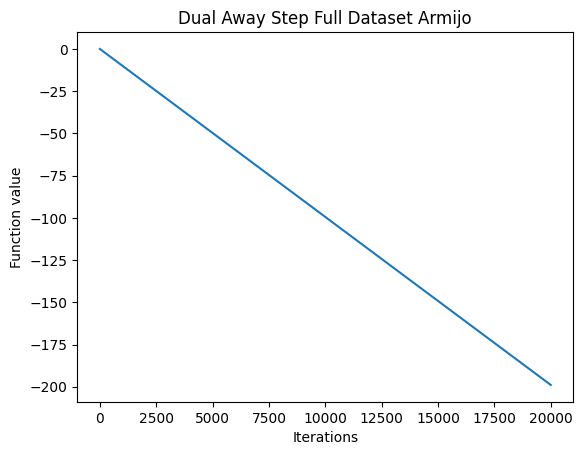

In [ ]:
plt.plot(dual_val_list_AS_fda)
plt.title('Dual Away Step Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

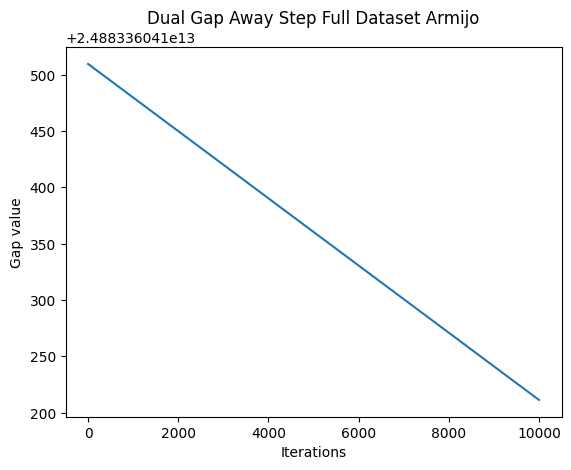

In [ ]:
plt.plot(dual_gap_list_AS_fda)
plt.title('Dual Gap Away Step Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Awaystep Standardized Dataset Armijo

In [ ]:
epsilon = 0.001

center_AS_sda, radius_AS_sda, count_iterations_AS_sda, total_time_AS_sda, dual_val_list_AS_sda, dual_gap_list_AS_sda = frankWolfe_AwayStep(Standardized_full_dataset, epsilon, max_iterations=10000, step_size="Armijo")

print("CENTER: ", center_AS_sda)
print("RADIUS: ", radius_AS_sda)
print("COUNT ITERATIONS: ", count_iterations_AS_sda)
print("TOTAL TIME: ", total_time_AS_sda)

CENTER:  [-0.17204213 -0.50586881 -0.19444982 -1.02984001  0.15574911 -1.02981054
  0.31758308 -1.02980044  0.58305477 -1.02981696 -1.02976307 -0.614599
  0.24790679  0.29102435  1.45783288  0.06788772  0.1061719   0.08478841
  0.10195155  0.0566454   0.09577424 -1.19382537  0.66881251 -0.96208156
  2.41393479]
RADIUS:  9.221514540246474
COUNT ITERATIONS:  3918
TOTAL TIME:  214.78395247459412


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm((df[pred_columns] - np.mean(Full_dataset, axis=0)) / np.std(Full_dataset, axis=0) - center_AS_sda, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_AS_sda

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),374.000000
1,False Negative (FN),5.000000
2,True Negative (TN),28.000000
3,False Positive (FP),76.000000
4,Precision,0.831111
5,Recall,0.986807
6,F1 Score,0.902292


Text(0, 0.5, 'Function value')

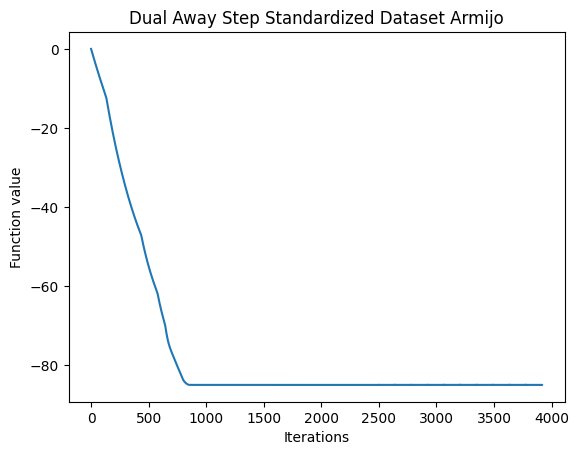

In [ ]:
plt.plot(dual_val_list_AS_sda)
plt.title('Dual Away Step Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

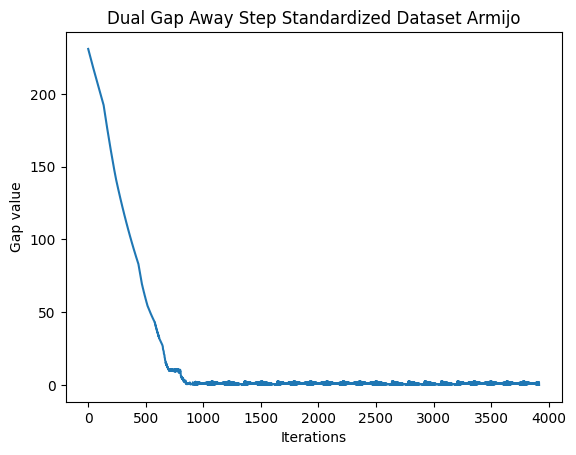

In [ ]:
plt.plot(dual_gap_list_AS_sda)
plt.title('Dual Gap Away Step Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Full Dataset Harmonic

In [ ]:
epsilon = 0.001

center_PFW_fdh, radius_PFW_fdh, count_iterations_PFW_fdh, total_time_PFW_fdh, dual_val_list_PFW_fdh, dual_gap_list_PFW_fdh = frankWolfe_Pairwise(Full_dataset, epsilon, max_iterations=10000, step_size  = "Harmonic")

print("CENTER: ", center_PFW_fdh)
print("RADIUS: ", radius_PFW_fdh)
print("COUNT ITERATIONS: ", count_iterations_PFW_fdh)
print("TOTAL TIME: ", total_time_PFW_fdh)

CENTER:  [2.49925606e+06 6.11050225e-01 7.32770125e-01 5.23788594e+04
 7.74138654e-01 5.23788700e+04 5.60592312e-01 5.23788767e+04
 4.38976798e-01 5.23788813e+04 5.23788685e+04 2.90548030e+01
 1.00436737e+00 2.84077994e-01 2.46077413e+01 1.87067290e+01
 1.76017455e+01 1.74097531e+01 1.73517589e+01 1.73412620e+01
 1.74677493e+01 1.10498354e+00 1.91992390e-01 5.79941649e-02
 1.04969546e-02]
RADIUS:  2494161.2021133252
COUNT ITERATIONS:  10000
TOTAL TIME:  56.35961031913757


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(df[pred_columns] - center_PFW_fdh, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_PFW_fdh

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),378.000000
1,False Negative (FN),1.000000
2,True Negative (TN),1.000000
3,False Positive (FP),103.000000
4,Precision,0.785863
5,Recall,0.997361
6,F1 Score,0.879070


Text(0, 0.5, 'Function value')

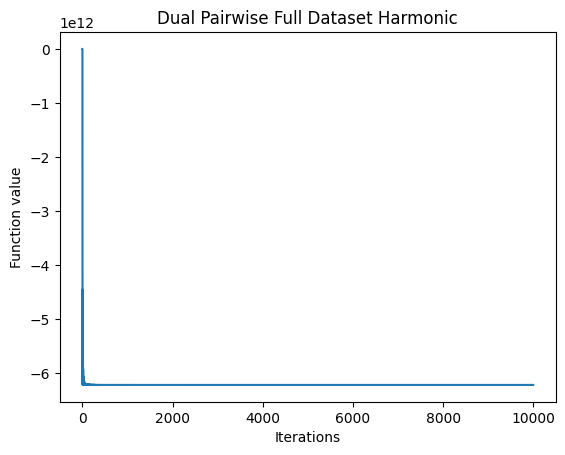

In [ ]:
plt.plot(dual_val_list_PFW_fdh)
plt.title('Dual Pairwise Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

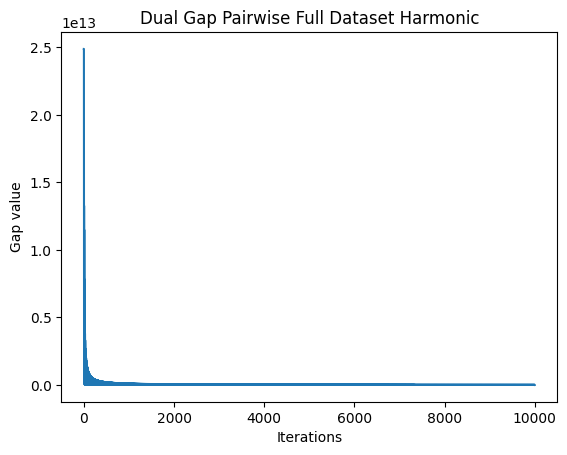

In [ ]:
plt.plot(dual_gap_list_PFW_fdh)
plt.title('Dual Gap Pairwise Full Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Standardized Dataset Harmonic

In [ ]:
epsilon = 0.001

center_PFW_sdh, radius_PFW_sdh, count_iterations_PFW_sdh, total_time_PFW_sdh, dual_val_list_PFW_sdh, dual_gap_list_PFW_sdh = frankWolfe_Pairwise(Standardized_full_dataset, epsilon, max_iterations=10000, step_size  = "Harmonic")

print("CENTER: ", center_PFW_sdh)
print("RADIUS: ", radius_PFW_sdh)
print("COUNT ITERATIONS: ", count_iterations_PFW_sdh)
print("TOTAL TIME: ", total_time_PFW_sdh)

CENTER:  [-0.17204503 -0.50696492 -0.19407289 -1.02920392  0.15622953 -1.02917447
  0.317809   -1.02916436  0.5832844  -1.02918088 -1.02912699 -0.61408827
  0.24829994  0.29120538  1.45771651  0.06771571  0.10597084  0.08459534
  0.10177209  0.05646547  0.09557615 -1.19286009  0.668534   -0.96288779
  2.41387672]
RADIUS:  9.22151447509845
COUNT ITERATIONS:  10000
TOTAL TIME:  40.8908486366272


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm((df[pred_columns] - np.mean(Full_dataset, axis=0)) / np.std(Full_dataset, axis=0) - center_PFW_sdh, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_PFW_sdh

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),377.000000
1,False Negative (FN),2.000000
2,True Negative (TN),28.000000
3,False Positive (FP),76.000000
4,Precision,0.832230
5,Recall,0.994723
6,F1 Score,0.906250


Text(0, 0.5, 'Function value')

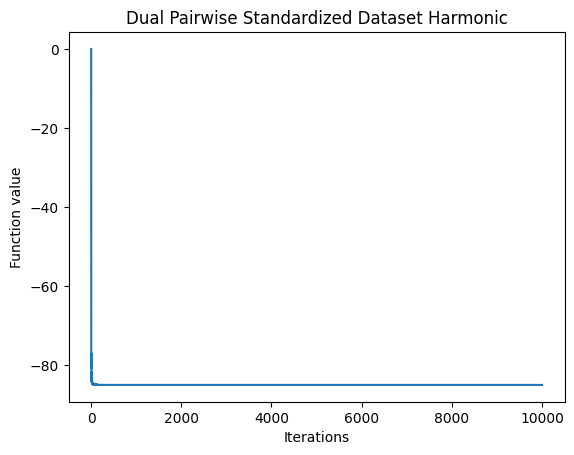

In [ ]:
plt.plot(dual_val_list_PFW_sdh)
plt.title('Dual Pairwise Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

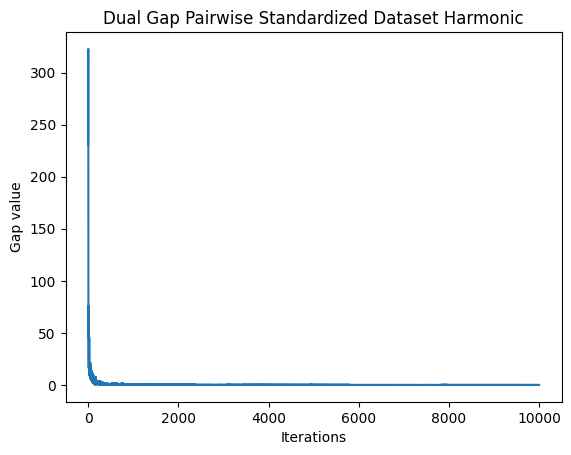

In [ ]:
plt.plot(dual_gap_list_PFW_sdh)
plt.title('Dual Gap Pairwise Standardized Dataset Harmonic')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Full Dataset Armijo

In [ ]:
epsilon = 0.001

center_PFW_fda, radius_PFW_fda, count_iterations_PFW_fda, total_time_PFW_fda, dual_val_list_PFW_fda, dual_gap_list_PFW_fda = frankWolfe_Pairwise(Full_dataset, epsilon, max_iterations=10000, step_size  = "Armijo")

print("CENTER: ", center_PFW_fda)
print("RADIUS: ", radius_PFW_fda)
print("COUNT ITERATIONS: ", count_iterations_PFW_fda)
print("TOTAL TIME: ", total_time_PFW_fda)

CENTER:  [4.09900002e+03 6.41754000e-01 5.34608251e-01 5.10752747e+04
 5.63838731e-01 5.10752889e+04 3.98325832e-01 5.10752951e+04
 3.17851245e-01 5.10752951e+04 5.10752882e+04 9.35678889e-01
 1.11585889e+00 8.90000016e-02 1.77500000e+01 1.81340008e+01
 1.69890003e+01 1.67770004e+01 1.67029991e+01 1.66849995e+01
 1.68460007e+01 1.14500046e+00 2.11999893e-01 7.40013123e-02
 1.79996490e-02]
RADIUS:  9.972449115614749
COUNT ITERATIONS:  10000
TOTAL TIME:  3078.8703866004944


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(df[pred_columns] - center_PFW_fda, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_PFW_fda

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),1.000000
1,False Negative (FN),378.000000
2,True Negative (TN),104.000000
3,False Positive (FP),0.000000
4,Precision,1.000000
5,Recall,0.002639
6,F1 Score,0.005263


Text(0, 0.5, 'Function value')

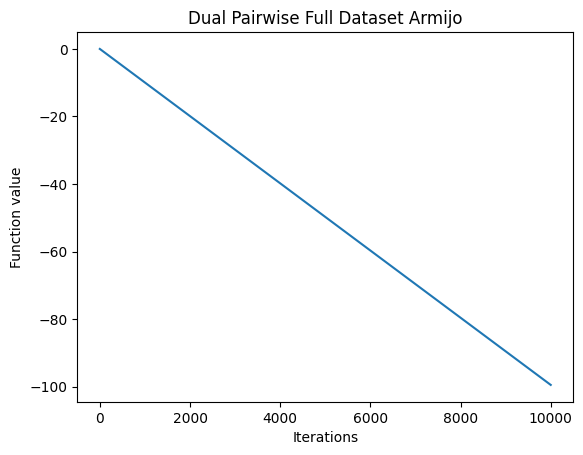

In [ ]:
plt.plot(dual_val_list_PFW_fda)
plt.title('Dual Pairwise Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

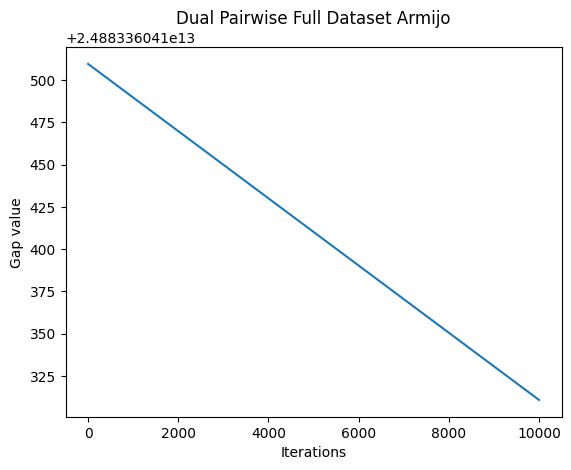

In [ ]:
plt.plot(dual_gap_list_PFW_fda)
plt.title('Dual Pairwise Full Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Pairwise Standardized Dataset Armijo

In [ ]:
epsilon = 0.001

center_PFW_sda, radius_PFW_sda, count_iterations_PFW_sda, total_time_PFW_sda, dual_val_list_PFW_sda, dual_gap_list_PFW_sda = frankWolfe_Pairwise(Standardized_full_dataset, epsilon, max_iterations=10000, step_size  = "Armijo")

print("CENTER: ", center_PFW_sda)
print("RADIUS: ", radius_PFW_sda)
print("COUNT ITERATIONS: ", count_iterations_PFW_sda)
print("TOTAL TIME: ", total_time_PFW_sda)

CENTER:  [-0.19714155 -0.47527876 -0.1850823  -1.02543335  0.16119669 -1.02540426
  0.32403166 -1.02539409  0.59637895 -1.02541056 -1.02535664 -0.60100828
  0.20963563  0.21730529  1.43218787  0.02814182  0.0663192   0.04500618
  0.06222042  0.01672205  0.0559675  -1.17096162  0.65956469 -0.97160496
  2.40582564]
RADIUS:  9.219375721064567
COUNT ITERATIONS:  10000
TOTAL TIME:  289.67738151550293


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm((df[pred_columns] - np.mean(Full_dataset, axis=0)) / np.std(Full_dataset, axis=0) - center_PFW_sda, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_PFW_sda

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),377.000000
1,False Negative (FN),2.000000
2,True Negative (TN),28.000000
3,False Positive (FP),76.000000
4,Precision,0.832230
5,Recall,0.994723
6,F1 Score,0.906250


Text(0, 0.5, 'Function value')

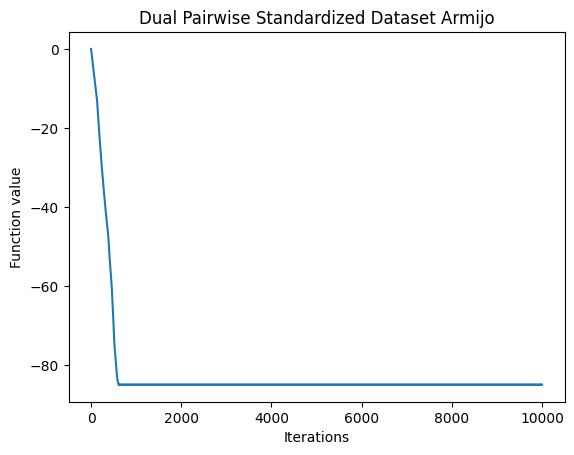

In [ ]:
plt.plot(dual_val_list_PFW_sda)
plt.title('Dual Pairwise Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Gap value')

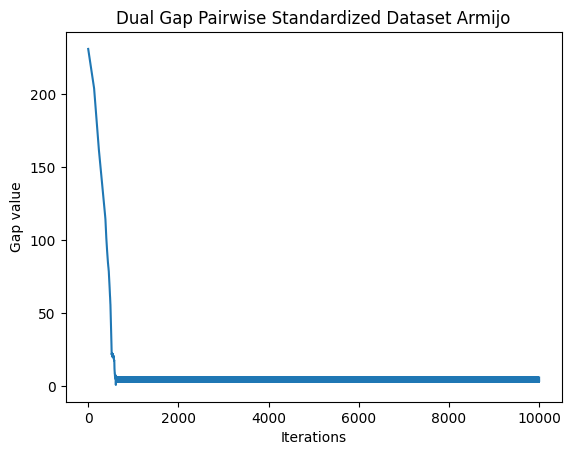

In [ ]:
plt.plot(dual_gap_list_PFW_sda)
plt.title('Dual Gap Pairwise Standardized Dataset Armijo')
plt.xlabel('Iterations')
plt.ylabel('Gap value')

Awaystep Full Dataset Exact Line Search

In [ ]:
epsilon = 0.001

center_AS_fde, radius_AS_fde, count_iterations_AS_fde, total_time_AS_fde, dual_val_list_AS_fde, dual_gap_list_AS_fde = frankWolfe_AwayStep(Full_dataset, epsilon, max_iterations=10000, step_size = "Exact")

print("CENTER: ", center_AS_fde)
print("RADIUS: ", radius_AS_fde)
print("COUNT ITERATIONS: ", count_iterations_AS_fde)
print("TOTAL TIME: ", total_time_AS_fde)

CENTER:  [2.49825850e+06 6.11062500e-01 7.32690900e-01 5.23783382e+04
 7.74054576e-01 5.23783488e+04 5.60527438e-01 5.23783556e+04
 4.38928372e-01 5.23783601e+04 5.23783474e+04 2.90435610e+01
 1.00441194e+00 2.84000002e-01 2.46049995e+01 1.87065001e+01
 1.76015005e+01 1.74095001e+01 1.73514996e+01 1.73409996e+01
 1.74675007e+01 1.10499954e+00 1.92000389e-01 5.80005646e-02
 1.04999542e-02]
RADIUS:  2494161.202113328
COUNT ITERATIONS:  1
TOTAL TIME:  0.01572561264038086


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(df[pred_columns] - center_AS_fde, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_AS_fde

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),379.000000
1,False Negative (FN),0.000000
2,True Negative (TN),1.000000
3,False Positive (FP),103.000000
4,Precision,0.786307
5,Recall,1.000000
6,F1 Score,0.880372


Text(0, 0.5, 'Function value')

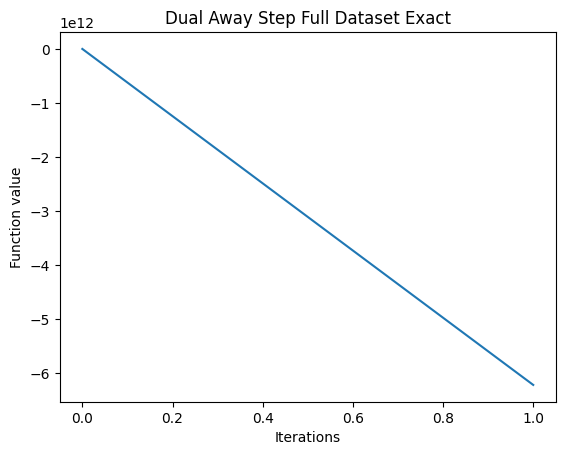

In [ ]:
plt.plot(dual_val_list_AS_fde)
plt.title('Dual Away Step Full Dataset Exact')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Function value')

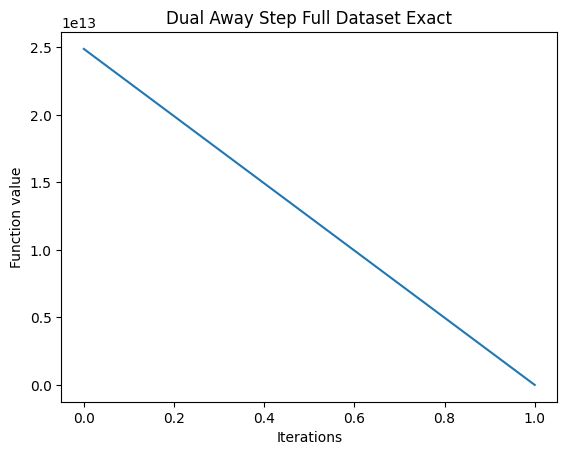

In [ ]:
plt.plot(dual_gap_list_AS_fde)
plt.title('Dual Away Step Full Dataset Exact')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Awaystep Standardized Dataset Exact Line Search

In [ ]:
epsilon = 0.001

center_AS_sde, radius_AS_sde, count_iterations_AS_sde, total_time_AS_sde, dual_val_list_AS_sde, dual_gap_list_AS_sde = frankWolfe_AwayStep(Standardized_full_dataset, epsilon, max_iterations=10000, step_size = "Exact")

print("CENTER: ", center_AS_sde)
print("RADIUS: ", radius_AS_sde)
print("COUNT ITERATIONS: ", count_iterations_AS_sde)
print("TOTAL TIME: ", total_time_AS_sde)

CENTER:  [-0.17197633 -0.50553062 -0.19441461 -1.02976933  0.15576372 -1.02973987
  0.31771881 -1.02972977  0.58321865 -1.02974629 -1.02969239 -0.61466816
  0.24763824  0.29091953  1.4578213   0.06779437  0.1060945   0.08471276
  0.10187348  0.05656738  0.09569782 -1.19426278  0.66874579 -0.96195684
  2.41389621]
RADIUS:  9.221514506656842
COUNT ITERATIONS:  73
TOTAL TIME:  0.43437838554382324


In [ ]:
pred_columns = ['__SIG2010_', 'Per', 'uAmp', 'T0_u', 'gAmp', 'T0_g', 'rAmp',
       'T0_r', 'iAmp', 'T0_i', 'T0_z', 'RAJ2000', 'DEJ2000', 'Ar', 'Dist',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Vmag', 'u-g', 'g-r', 'r-i',
       'i-z']

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm((df[pred_columns] - np.mean(Full_dataset, axis=0)) / np.std(Full_dataset, axis=0) - center_AS_sde, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
df['InsideBall'] = distances < radius_AS_sde

positive_class = b'ab'
negative_class = b'c '
measure_accuracy(negative_class, positive_class, df)

,Metric,Count
0,True Positive (TP),374.000000
1,False Negative (FN),5.000000
2,True Negative (TN),28.000000
3,False Positive (FP),76.000000
4,Precision,0.831111
5,Recall,0.986807
6,F1 Score,0.902292


Text(0, 0.5, 'Function value')

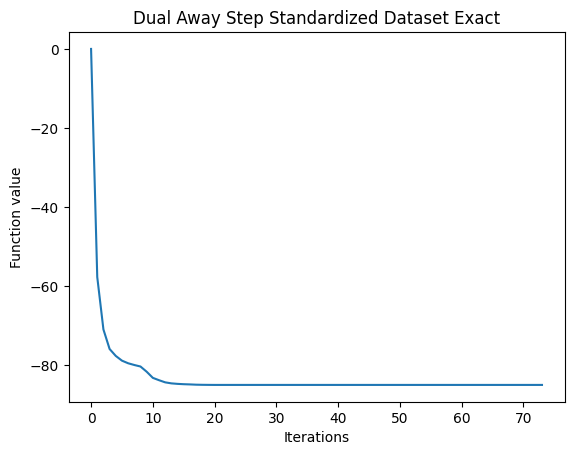

In [ ]:
plt.plot(dual_val_list_AS_sde)
plt.title('Dual Away Step Standardized Dataset Exact')
plt.xlabel('Iterations')
plt.ylabel('Function value')

Text(0, 0.5, 'Function value')

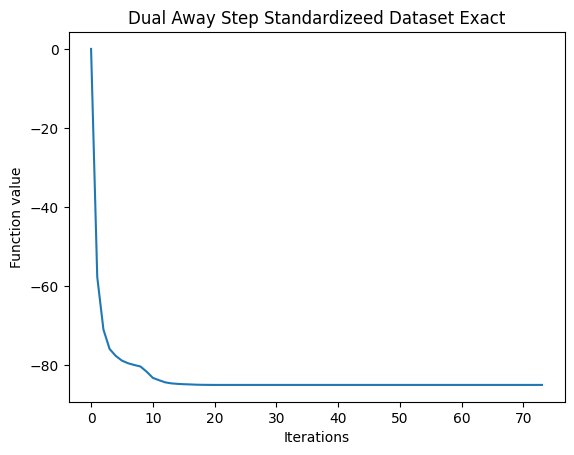

In [ ]:
plt.plot(dual_val_list_AS_sde)
plt.title('Dual Away Step Standardizeed Dataset Exact')
plt.xlabel('Iterations')
plt.ylabel('Function value')

# SSDS Quasar-Galaxy Classification

In [70]:
# open the pulsar dataset
qso_g_df = pd.read_csv('datasets/corrected_QSO_GALAXY_Dataset.csv')

# drop the rows with missing values
qso_g_df = qso_g_df.dropna()
qso_g_df.rename(columns={'class': 'type'}, inplace=True)

galaxy_df = qso_g_df[qso_g_df['type'] == 'GALAXY'].sample(n=2000, random_state=42)
qso_df = qso_g_df[qso_g_df['type'] == 'QSO'].sample(n=2000, random_state=42)

qso_g_df = pd.concat([galaxy_df, qso_df])

display(qso_g_df.head())

,type,subclass,mag_u,mag_g,mag_r,mag_i,mag_z,redshift,flux_u,flux_g,...,flux_i,flux_z,photRA,specRA,photDec,specDec,petrosianRadius_u,deVEffectiveRadius_u,petrosianRadius_z,deVEffectiveRadius_z
4498,GALAXY,STARFORMING,20.20175,18.42369,17.36100,16.85209,16.42140,0.116623,4.067745,11.13524,...,51.35847,72.29363,218.563632,218.56364,8.992736,8.992744,2.970685,7.054471,5.191600,2.716197
3646,GALAXY,STARFORMING,19.64754,18.41117,17.75667,17.36501,17.06143,0.073963,3.827840,8.99992,...,29.52955,37.28042,339.559695,339.55971,14.157285,14.157290,43.764050,26.746740,8.903262,10.204720
4242,GALAXY,STARFORMING,19.61266,17.91331,17.00628,16.59109,16.24816,0.107316,6.293722,25.02789,...,96.43300,125.75090,120.833410,120.83341,12.104724,12.104733,8.076633,6.684969,3.399417,1.761480
2464,GALAXY,STARFORMING,18.55299,17.09966,16.39841,16.01200,15.75324,0.066666,18.779910,47.22098,...,135.92570,166.69580,180.117997,180.11801,51.756060,51.756076,5.504677,4.108453,4.365156,2.409809
8715,GALAXY,STARFORMING,16.71037,15.61988,15.25153,15.01981,14.84542,0.027207,18.918650,32.80019,...,72.02156,87.63742,158.926025,158.92608,5.615982,5.615976,17.752350,29.677330,16.224320,28.178960


In [71]:
qso_g_df['u-g'] = qso_g_df['flux_u'] - qso_g_df['flux_g']
qso_g_df['g-r'] = qso_g_df['flux_g'] - qso_g_df['flux_r']
qso_g_df['r-i'] = qso_g_df['flux_r'] - qso_g_df['flux_i']
qso_g_df['i-z'] = qso_g_df['flux_i'] - qso_g_df['flux_z']
qso_g_df['u-z'] = qso_g_df['flux_u'] - qso_g_df['flux_z']
qso_g_df['u-r'] = qso_g_df['flux_u'] - qso_g_df['flux_r']
qso_g_df['r-z'] = qso_g_df['flux_r'] - qso_g_df['flux_z']


pred_columns_qso_g = ['u-z', 'u-r', 'r-z', 'redshift']

In [72]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
scaler = StandardScaler()

qso_g_df_norm = qso_g_df[pred_columns_qso_g]
# fit and transform the data

qso_g_df_norm = pd.DataFrame(scaler.fit_transform(qso_g_df_norm), columns=pred_columns_qso_g)

# add the 'type' column back to the normalized DataFrame
qso_g_df_norm['type'] = qso_g_df['type'].values

display(qso_g_df_norm.head())

,u-z,u-r,r-z,redshift,type
0,-0.305543,-0.156948,-0.435702,-0.815634,GALAXY
1,0.136068,0.155662,0.116330,-0.861102,GALAXY
2,-0.956166,-0.946658,-0.950819,-0.825554,GALAXY
3,-1.317584,-1.429763,-1.196716,-0.868880,GALAXY
4,-0.311803,-0.397975,-0.229181,-0.910937,GALAXY


In [73]:
from scipy import stats

train_set = qso_g_df_norm[qso_g_df_norm['type'] == 'QSO']

outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns_qso_g])) > 0.5).all(axis=1)]
train_set = train_set[~train_set.isin(outliers)].dropna()

In [74]:
c_qso_g, r_qso_g, count_iterations_AS_sde, total_time_AS_sde, dual_val_list_AS_sde, dual_gap_list_AS_sde = frankWolfe_AwayStep(train_set[pred_columns_qso_g].iloc[:len(train_set)//2].values, 0.1, max_iterations=10000, step_size = "Exact")

# Calculate the Euclidean distance from each point to the center
distances = np.linalg.norm(qso_g_df_norm[pred_columns_qso_g] - c_qso_g, axis=1)

# Add a new boolean column indicating whether the point is inside the ball
qso_g_df_norm['InsideBall'] = distances < r_qso_g


measure_accuracy('GALAXY', 'QSO', qso_g_df_norm)

,Metric,Count
0,True Positive (TP),1984.000000
1,False Negative (FN),16.000000
2,True Negative (TN),1454.000000
3,False Positive (FP),546.000000
4,Precision,0.784190
5,Recall,0.992000
6,F1 Score,0.875938


# Red Dwarfs vs. White Dwarfs

In [75]:
red_dwarfs = pd.read_csv('datasets/red_dwarfs.csv')
white_dwarfs = pd.read_csv('datasets/white_dwarfs.csv')

red_dwarfs['type'] = 'red'
white_dwarfs['type'] = 'white'

red_dwarfs = red_dwarfs[red_dwarfs['subclass'].str.startswith('K') | red_dwarfs['subclass'].str.startswith('M')]
white_dwarfs = white_dwarfs[white_dwarfs['subclass'] == 'WD']

red_dwarfs = red_dwarfs.iloc[:2000]
white_dwarfs = white_dwarfs.iloc[:2000]

dwarfs = pd.concat([red_dwarfs, white_dwarfs], ignore_index=True)

dwarfs = dwarfs.dropna()

#dwarfs = dwarfs.sample(frac=1).reset_index(drop=True)

display(dwarfs.head())

,spectroFlux_u,spectroFlux_g,spectroFlux_r,spectroFlux_i,spectroFlux_z,class,subclass,type
0,0.690362,2.639864,6.609772,9.040903,10.89239,STAR,K1,red
1,1.696024,5.127242,11.380340,15.288570,18.13893,STAR,K1,red
2,1.939370,6.556342,14.391160,19.006530,22.24492,STAR,K1,red
3,2.038488,9.414086,19.352240,25.074530,29.21216,STAR,K1,red
4,1.535014,5.447570,11.538370,15.077310,20.65042,STAR,K1,red


In [76]:
dwarfs['u-g'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_g']
dwarfs['g-r'] = dwarfs['spectroFlux_g'] - dwarfs['spectroFlux_r']
dwarfs['r-i'] = dwarfs['spectroFlux_r'] - dwarfs['spectroFlux_i']
dwarfs['i-z'] = dwarfs['spectroFlux_i'] - dwarfs['spectroFlux_z']
dwarfs['u-r'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_r']
dwarfs['r-z'] = dwarfs['spectroFlux_r'] - dwarfs['spectroFlux_z']
dwarfs['u-z'] = dwarfs['spectroFlux_u'] - dwarfs['spectroFlux_z']

pred_columns = ['u-g', 'g-r', 'r-i', 'i-z']
train_set = dwarfs[dwarfs['type'] == "white"]